In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

# Load dataset
try:
    df = pd.read_csv("climate_risk_dataset.csv")
    print(df.head())  # Display the first few rows
except FileNotFoundError:
    print("Error: 'climate_risk_dataset.csv' not found. Please check the file path.")
except pd.errors.ParserError:
    print("Error: Failed to parse CSV. Please check the file format.")

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


📊 Shape of dataset: (517, 13)

🧾 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB

📈 Summary Statistics:
                 X           Y month  day        FFMC         DMC          DC  \
count   517.000000  517.000000   517  517  517.000000  517.000000  517.000000   
unique         NaN         NaN    12    7    

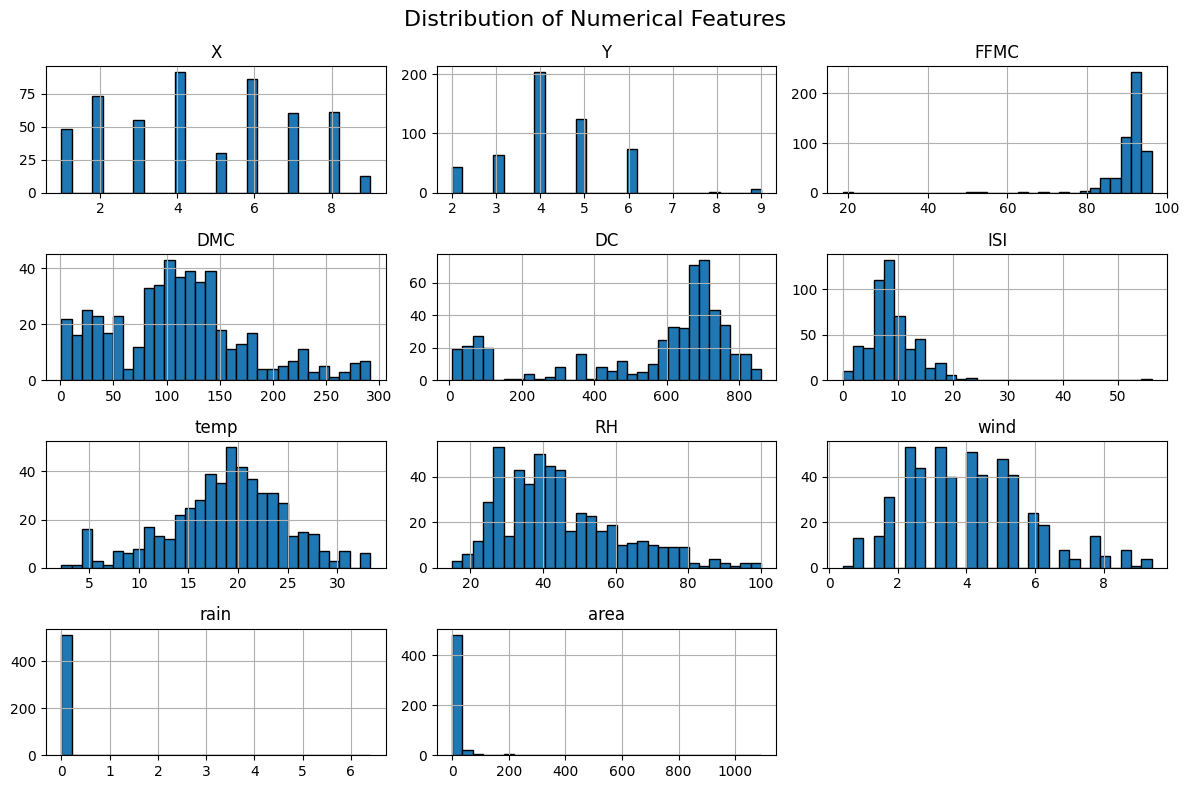

c:\Users\bhanu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


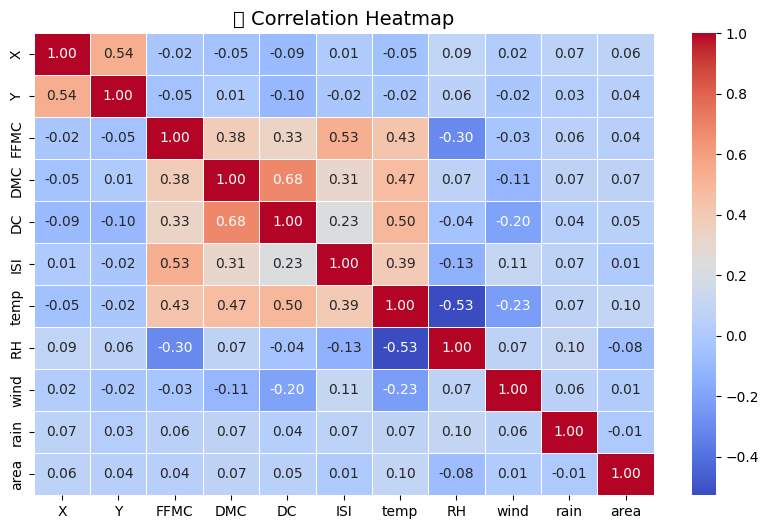

In [3]:
# Basic Info
print("📊 Shape of dataset:", df.shape)

print("\n🧾 Dataset Info:")
df_info = df.info()  # This already prints to console, no need to wrap in print()

print("\n📈 Summary Statistics:")
print(df.describe(include='all'))  # include='all' shows stats for both numeric and categorical columns

# Check for missing values
print("\n🔍 Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Only show columns with missing data

# Distribution of numerical columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if numeric_cols:
    df[numeric_cols].hist(figsize=(12, 8), bins=30, edgecolor='black')
    plt.suptitle("Distribution of Numerical Features", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for histogram.")

# Correlation Heatmap
if len(numeric_cols) >= 2:
    plt.figure(figsize=(10, 6))
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("🔗 Correlation Heatmap", fontsize=14)
    plt.show()
else:
    print("Not enough numerical columns for correlation heatmap.")

In [4]:

# Handle missing values (drop or fill with mean for numerical, mode for categorical)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())

# Encode categorical variables
label_enc = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = label_enc.fit_transform(df[col])

# Standardize numerical features
scaler = StandardScaler()
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1.008313,0.569860,0.284222,-1.423121,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202
1,1.008313,-0.244001,0.970871,1.176715,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202
2,1.008313,-0.244001,0.970871,-0.383187,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202
3,1.440925,1.383722,0.284222,-1.423121,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202
4,1.440925,1.383722,0.284222,0.136781,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define target column
target_col = "Fire"

# Check if target exists
if target_col in df.columns:
    y = df[target_col]
    X = df.drop(columns=[target_col], errors="ignore")

    # Drop non-numeric columns for correlation and SelectKBest
    X_numeric = X.select_dtypes(include=np.number).copy()

    # Fill missing values (optional: customize strategy)
    X_numeric.fillna(X_numeric.mean(), inplace=True)

    # Method 1: Correlation check
    corr = df.corr(numeric_only=True)[target_col].sort_values(ascending=False)
    print("📊 Correlation with target:\n", corr)

    # Method 2: SelectKBest
    selector = SelectKBest(score_func=f_classif, k=min(5, X_numeric.shape[1]))
    X_new = selector.fit_transform(X_numeric, y)
    selected_features = X_numeric.columns[selector.get_support()]
    print("\n✅ Top Features (SelectKBest):", selected_features.tolist())

    # Method 3: Feature Importance using RandomForest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_numeric, y)
    importances = pd.Series(rf.feature_importances_, index=X_numeric.columns)
    print("\n🌲 RandomForest Feature Importances:\n", importances.sort_values(ascending=False).head(10))

    # Plot feature importance
    importances.sort_values(ascending=False).head(10).plot(kind="barh", figsize=(8, 5), color='skyblue')
    plt.title("Top 10 Important Features")
    plt.xlabel("Importance Score")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Target column 'Fire' not found. Please adjust target_col variable.")

⚠️ Target column 'Fire' not found. Please adjust target_col variable.
